<a href="https://colab.research.google.com/github/toweliewang/DL/blob/master/day3_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd
%cd drive/My Drive/Colab Notebooks
!pwd

/content
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks


In [3]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15961840965380374388, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8880593391394509858
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13052106170324598503
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 631532150308698916
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

Create dataset...
Finalizing all the data ....
Creating lstm model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 211, 24)]         0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 207, 32)           3872      
_________________________________________________________________
dropout_6 (Dropout)          (None, 207, 32)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 203, 32)           5152      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 101, 32)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 101, 32)           128       
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


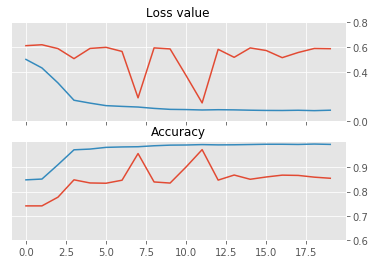

ValueError: ignored

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  7 10:00:55 2017

@author: NPBME
"""

import h5py
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from keras import optimizers

                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'


# Retrieve data  --------------------------------------------------------------
#
#
#


f                   = h5py.File('cad5sec.mat')
X                   = f["data"]
Y                   = f["classLabel"]
data                = np.array(X)
data                = np.transpose(data)
label               = np.array(Y)
label               = np.transpose(label)


nor                 = data[0:32000]
cad                 = data[32000:38120]



# stepzation function ---------------------------------------------------------
#
#
# This function creates segmenets of a 1D signal
# It works in batch
#
#
# Dependency:       numpy

def makeSteps(dat, length, dist):
    width           = dat.shape[1]
    numOfSteps      = int(np.floor((width-length)/dist)+1)
    
                                        # Initialize the output
    segments        = np.zeros([dat.shape[0],numOfSteps,length],
                               dtype=dat.dtype)
    
    for l in range(numOfSteps):
        segments[:,l,:]     = dat[:,(l*dist):(l*dist+length)]
        
    return segments





# Splitting data into training and testing set---------------------------------
#
#
#


print('Create dataset...')
trNor               = nor[0:28800].copy()
tsNor               = nor[28800:32000].copy()
trCad               = cad[0:5000].copy()
tsCad               = cad[5000:6120].copy()




# Create segments from the signals --------------------------------------------
#
#
#

length              = 24
dist                = 6

print('Finalizing all the data ....')
trNorS              = makeSteps(trNor, length, dist)
tsNorS              = makeSteps(tsNor, length, dist)
trCadS              = makeSteps(trCad, length, dist)
tsCadS              = makeSteps(tsCad, length, dist)

trDat               = np.vstack([trNorS,trCadS])
tsDat               = np.vstack([tsNorS,tsCadS])

trLbl               = np.vstack([np.zeros([trNorS.shape[0],1]),
                                 np.ones([trCadS.shape[0],1])])
tsLbl               = np.vstack([np.zeros([tsNorS.shape[0],1]),
                                 np.ones([tsCadS.shape[0],1])])






# Creating model --------------------------------------------------------------
#
#
#


print('Creating lstm model...')

modelname   = 'wks3_2_2'

length = 24
dist = 6

# ValueError: You are trying to load a weight file containing 9 layers into a model with 11 layers.

def createModel(): 
  inputs = Input(shape=(trDat.shape[1],length))
  #,kernel_initializer=he_normal(33)
  y = Conv1D(32, 5, activation='relu')(inputs)
  y = Dropout(0.25)(y)
  y = Conv1D(32, 5, activation='relu')(y)
  y = MaxPooling1D(2)(y)
  #x = BatchNormalization()(x)
  y = BatchNormalization()(y)
  y = Conv1D(48, 5, activation='relu')(y)
  y = Dropout(0.5)(y)
  y = Conv1D(48, 5, activation='relu')(y)
  y = MaxPooling1D(2)(y)
 
  
  y = Conv1D(64, 5, activation='relu')(y)  
  y = Dropout(0.5)(y)
  y = Conv1D(64, 5, activation='relu')(y)  
  y = MaxPooling1D(2)(y)
  
  y = LSTM(8,
  return_sequences=True,
  dropout=0.5,
  recurrent_dropout=0.5)(y)
  y = LSTM(4,
  return_sequences=True,
  dropout=0.5,
  recurrent_dropout=0.5)(y)
  y = LSTM(2)(y)
  #kernel_regularizer=regularizers.l2(0.01)
  y = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(y)
  model = Model(inputs=inputs,outputs=y)
  # add adam change lr from 0.001 --0.005
  adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  
  model.compile(loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])
  return model





                            # Setup the models
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

# .............................................................................


                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]



# .............................................................................


                            # Fit the model
                            # This is where the training starts
model.fit(trDat, 
          trLbl, 
          validation_data=(tsDat, tsLbl), 
          epochs=20,  #40
          batch_size=64, #128
          shuffle=True,
          callbacks=callbacks_list)




# ......................................................................


                            # Now the training is complete, we get
                            # another object to load the weights
                            # compile it, so that we can do 
                            # final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

 



# .......................................................................


                            # Make classification on the test dataset
predicts    = modelGo.predict(tsDat)

labelname   = ['Normal','CAD']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(tsLbl,predicts.round())
confusion   = metrics.confusion_matrix(tsLbl,predicts.round())


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(tsLbl,predicts.round(),target_names=labelname,digits=4))
print(confusion)


    
    
    
# ..................................................................
    
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()




# ................................................................

from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file=modelname+'_model.pdf', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

